<a href="https://colab.research.google.com/github/harjasdt/Deep_Learning/blob/main/Final_Rise11_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Rise 11 social media post sentimental analysis - Harjaspreet Singh**




**Setup & Config**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import re

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 6, 4

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Data Exploration**

We'll load the Social Media reviews dataset, shared on the mail:

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,text,Y
0,advice Talk neighbours family exchange phone n...,2
1,Coronavirus Australia: Woolworths give elderly...,2
2,"My food stock one empty... PLEASE, panic, THER...",2
3,"Me, ready go supermarket outbreak. Not I'm par...",0
4,As news regionÂs first confirmed COVID- case ...,2


In [ ]:
df.shape

(41152, 2)

We have about ~41k examples. Let's check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41152 entries, 0 to 41151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    41152 non-null  object
 1   Y       41152 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 643.1+ KB


Great, no missing values in the Y and texts column! Lets check for NA values and drop them if any.

In [ ]:
df.isna().any()

text    False
Y       False
dtype: bool

Lets look at our Y(results):

In [ ]:
df.Y.unique()

array([2, 0, 1])

<Axes: >

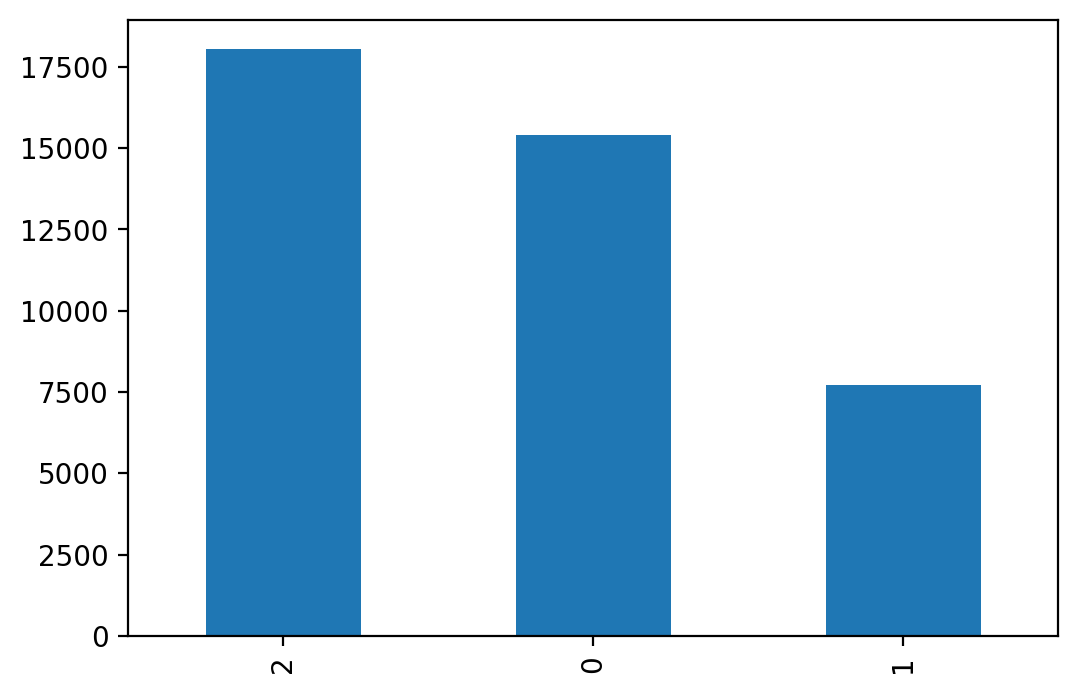

In [ ]:
df.Y.value_counts().plot(kind='bar')

**Data Preprocessing**

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Let's load a pre-trained [BertTokenizer]:

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) # Removed @mentions
    text = re.sub(r'#','',text) #Removing the # symbols
    text = re.sub(r':','',text) #Removing the : symbols
    text = re.sub(r'_','',text) #Removing the _ symbols
    text = re.sub(r'RT[\s]+','',text) #Removing RT
    text = re.sub(r'https?:\/\/\S+','', text) # Removing the hyper link
    return text
df['text']=df['text'].apply(cleanText)

In [ ]:
df

,text,Y
0,advice Talk neighbours family exchange phone n...,2
1,"Coronavirus Australia Woolworths give elderly,...",2
2,"My food stock one empty... PLEASE, panic, THER...",2
3,"Me, ready go supermarket outbreak. Not I'm par...",0
4,As news regionÂs first confirmed COVID- case ...,2
...,...,...
41147,Airline pilots offering stock supermarket shel...,1
41148,Response complaint provided citing COVID- rela...,0
41149,You know itÂs getting tough rationing toilet ...,2
41150,Is wrong smell hand sanitizer starting turn on?,1


Choosing Sequence Length

In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


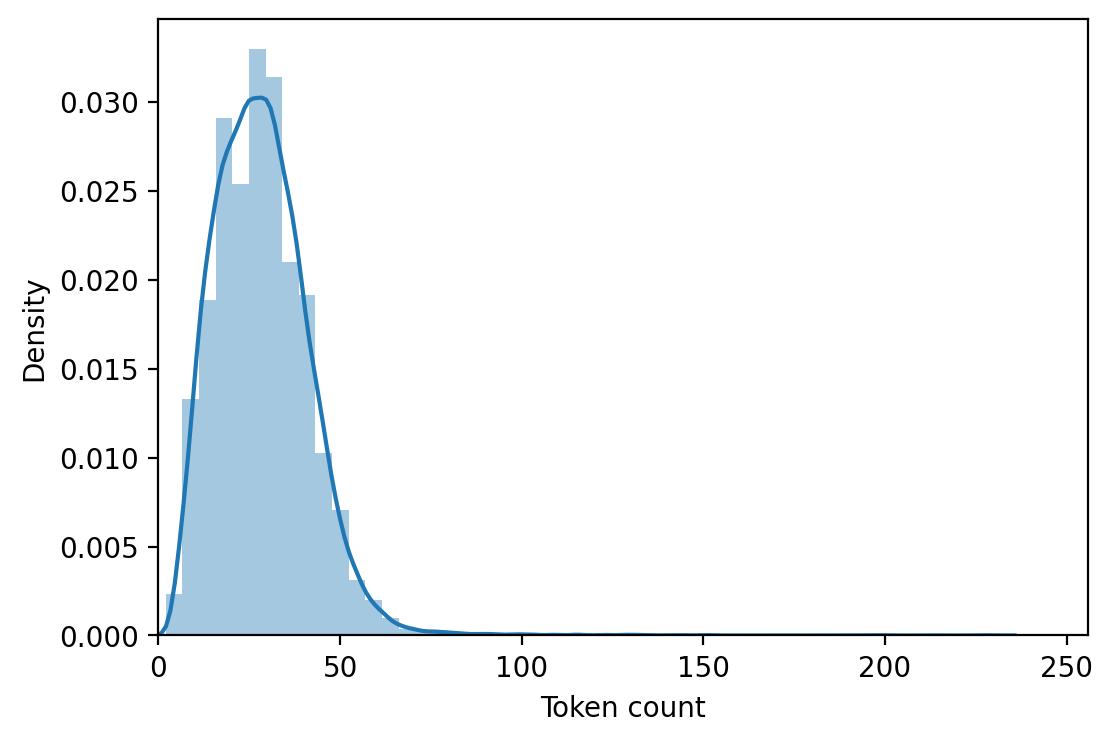

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 70 tokens, but we'll be on the
safe side and choose a maximum length of 100.

In [ ]:
MAX_LEN = 100

Create a PyTorch dataset:

---



In [ ]:
class SentiDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Let's split the data: 80-10-10

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((32921, 2), (4115, 2), (4116, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentiDataset(
    reviews=df.text.to_numpy(),
    targets=df.Y.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Sentiment Classification with BERT and Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(3)
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

Training

In [ ]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())


  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.5632404739415477 accuracy 0.7804440934358008
Val   loss 0.39104352706624557 accuracy 0.8680437424058324

Epoch 2/2
----------
Train loss 0.3186487471177971 accuracy 0.9001549163148143
Val   loss 0.3979043942017033 accuracy 0.8782503037667072

CPU times: user 13min 41s, sys: 5min 48s, total: 19min 30s
Wall time: 20min 4s


We're storing the state of the best model, indicated by the highest validation accuracy.

We can look at the training vs validation accuracy:

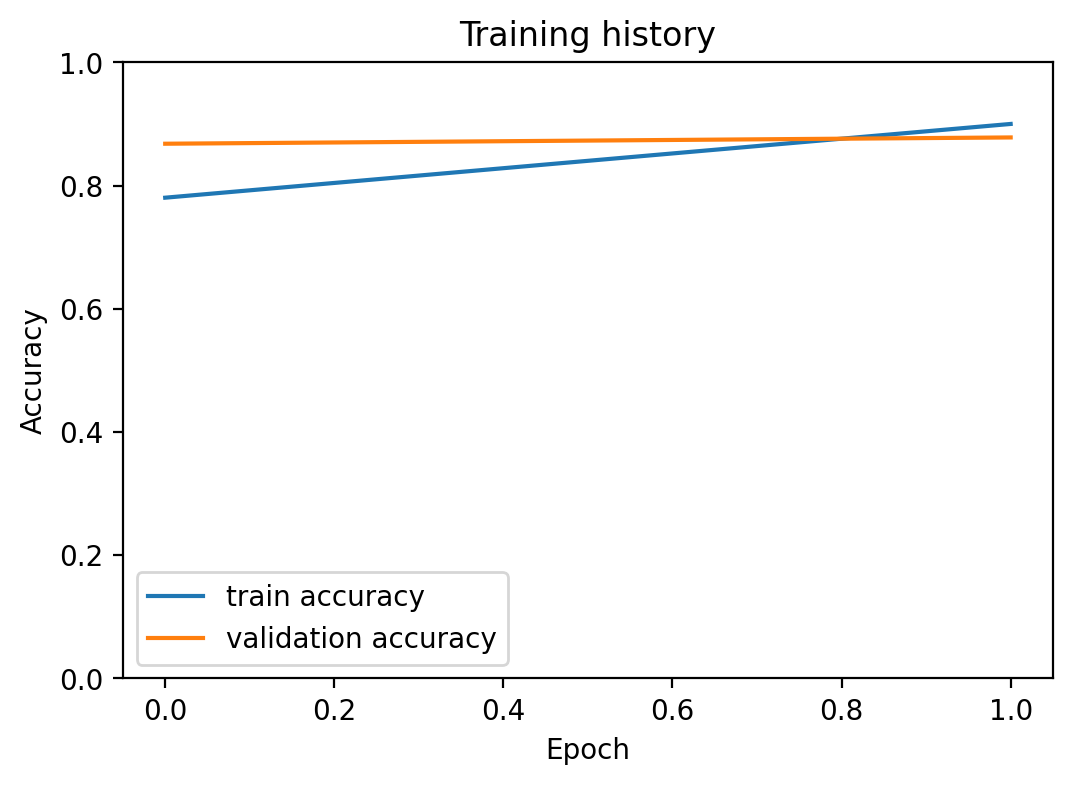

In [ ]:
plt.plot(torch.tensor(history['train_acc']).numpy(), label='train accuracy')
plt.plot(torch.tensor(history['val_acc']).numpy(), label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8811953352769679

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
class_names=['0','1','2']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1550
           1       0.88      0.81      0.85       759
           2       0.89      0.91      0.90      1807

    accuracy                           0.88      4116
   macro avg       0.88      0.87      0.87      4116
weighted avg       0.88      0.88      0.88      4116



We'll continue with the confusion matrix:

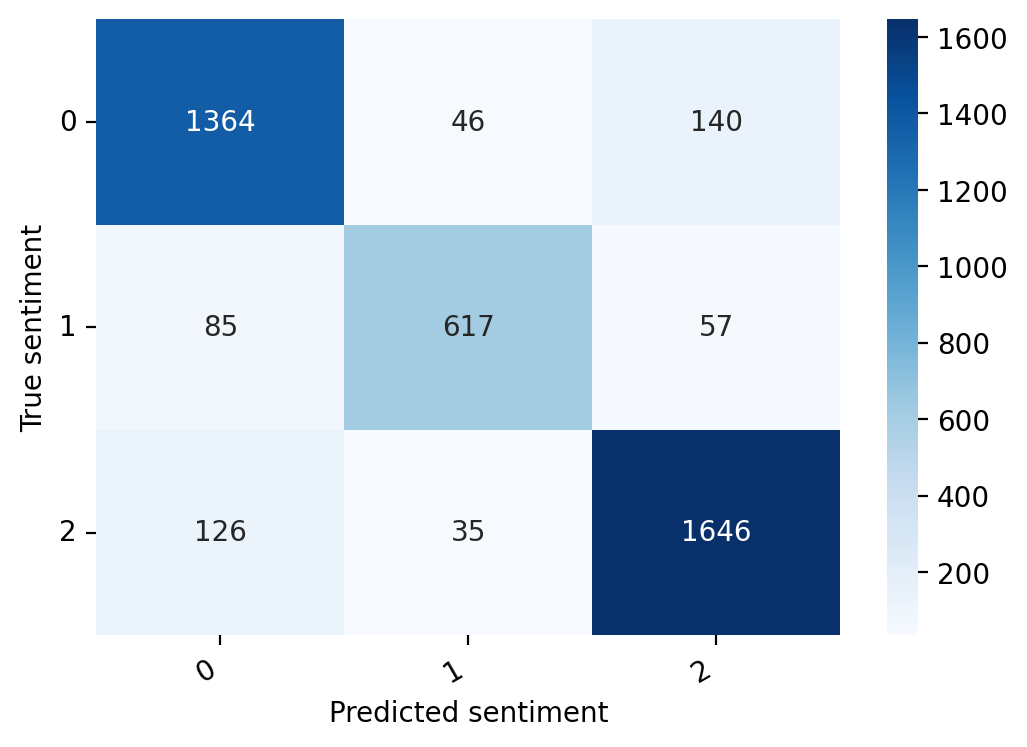

In [ ]:
class_names=['0','1','2']
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
df

,text,Y
0,advice Talk neighbours family exchange phone n...,2
1,"Coronavirus Australia Woolworths give elderly,...",2
2,"My food stock one empty... PLEASE, panic, THER...",2
3,"Me, ready go supermarket outbreak. Not I'm par...",0
4,As news regionÂs first confirmed COVID- case ...,2
...,...,...
41147,Airline pilots offering stock supermarket shel...,1
41148,Response complaint provided citing COVID- rela...,0
41149,You know itÂs getting tough rationing toilet ...,2
41150,Is wrong smell hand sanitizer starting turn on?,1


In [ ]:
review_text = "The COVID- coronavirus pandemic impacting consumer shopping behavior, purchase decisions retail sales, according First Insight study."

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: The COVID- coronavirus pandemic impacting consumer shopping behavior, purchase decisions retail sales, according First Insight study.
Sentiment  : 1
